# 📊 Neural Network (Multi-Layer Perceptron) Model for Student Outcome Prediction

## 🎯 **Notebook Overview**

This notebook implements and optimizes a **Neural Network (Multi-Layer Perceptron) classifier** to predict student academic outcomes in online learning environments. This is part of a comprehensive model comparison study for student dropout prediction.

### 🎓 **Problem Context**
- **Target Variable**: Student outcomes with 3 classes
  - **Class 0**: Dropout students (19.1% - minority class)
  - **Class 1**: At-risk students (25.4%)
  - **Class 2**: Successful students (55.5% - majority class)

## 🏆 **Key Results Summary**

### 📊 **Model Performance**
- **Dropout Recall (Primary Metric)**: **18.67%** - Detection of at-risk students (class 0)
- **Test Accuracy**: **56.66%** - Overall classification performance
- **F1-Weighted**: **53.85%** - Balanced performance across all classes
- **F1-Macro**: **43.99%** - Unweighted class performance
- **Best CV Dropout Recall**: **18.67% ± 1.06%** - Cross-validation performance
- **Training Runtime**: **47.4 minutes** - GridSearchCV optimization time

### ⚙️ **Optimal Configuration**
- **Architecture**: (100, 50) - Two hidden layers with 100 and 50 neurons
- **Activation Function**: Tanh - Hyperbolic tangent activation
- **Solver**: LBFGS - Limited-memory BFGS optimization
- **Regularization**: Alpha = 0.001 (L2 penalty for weight control)
- **Learning Rate**: 0.01 - Initial learning rate
- **Training Iterations**: 500 - Converged to maximum iterations
- **Dropout-Focused Optimization**: Custom scoring metrics prioritize minority class detection

### 🎯 **Top Predictive Features** (via Permutation Importance)
1. **student_engagement** (0.0357) - Overall engagement level
2. **excellent_Score** (0.0352) - Academic excellence indicator  
3. **active_in_VLE** (0.0049) - Virtual learning engagement

### 💡 **Key Insights**
- **Neural Network Architecture**: Automatically learns complex feature interactions
- **Feature Scaling**: StandardScaler applied - critical for neural network performance
- **Full Training**: Model used all 500 iterations (max_iter reached)
- **Class Imbalance**: Dropout-focused scoring metrics optimize minority class detection
- **Complex Model**: 4 total layers with significant learning capacity
- **Optimization**: 120 parameter combinations tested in 47.4 minutes (SMART grid)

---

## 🔧 **Technical Details**

### **Key Features**
- **Class Imbalance Handling**: Dropout-focused scoring metrics to improve minority class detection
- **Hyperparameter Optimization**: Comprehensive GridSearchCV with 120+ parameter combinations
- **Feature Scaling**: StandardScaler preprocessing for optimal neural network performance
- **Early Stopping**: Automatic convergence detection to prevent overfitting
- **Permutation Feature Importance**: Model-agnostic feature importance analysis
- **Comprehensive Evaluation**: Cross-validation, confusion matrices, and detailed performance reports

### 📈 **Neural Network Architecture**
- **Input Layer**: 20 features (after encoding and scaling)
- **Hidden Layer 1**: 100 neurons with Tanh activation
- **Hidden Layer 2**: 50 neurons with Tanh activation  
- **Output Layer**: 3 classes with softmax activation
- **Total Parameters**: Approximately 7,203 trainable parameters
- **Solver**: LBFGS for batch optimization

### 🔗 **Integration**
This notebook is part of a systematic model comparison framework that evaluates multiple algorithms (Random Forest, KNN, LightGBM, SVM, Logistic Regression) to identify the best approach for student outcome prediction.

---


In [36]:
# ================================================================
# 1: IMPORT LIBRARIES & SETUP
# ================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import cross_val_score, GridSearchCV
import warnings
warnings.filterwarnings('ignore')
import time
import os
import joblib
import json
from datetime import datetime

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('default')
sns.set_palette(["#2E8B57"])   # Sea green color for neural networks

print("📚 Libraries imported successfully!")
print("🧠 Neural Network requires feature scaling - StandardScaler will be applied")
print("⚡ MLPClassifier with early stopping will be used for efficiency")

📚 Libraries imported successfully!
🧠 Neural Network requires feature scaling - StandardScaler will be applied
⚡ MLPClassifier with early stopping will be used for efficiency


In [37]:
# ================================================================
# 2: LOAD SAVED DATA
# ================================================================
print("📂 Loading saved training and test data...")
print("=" * 50)

try:
    # Load features
    X_train_raw = pd.read_csv('../Data/output/X_train_encoded.csv')
    X_test_raw = pd.read_csv('../Data/output/X_test_encoded.csv')
    
    # Load labels
    y_train_nn = pd.read_csv('../Data/output/y_train.csv').squeeze()  # squeeze() converts DataFrame to Series
    y_test_nn = pd.read_csv('../Data/output/y_test.csv').squeeze()
    
    print("✅ Data loaded successfully!")
    print(f"   Training features: {X_train_raw.shape}")
    print(f"   Test features: {X_test_raw.shape}")
    print(f"   Training labels: {y_train_nn.shape}")
    print(f"   Test labels: {y_test_nn.shape}")
    
except FileNotFoundError as e:
    print(f"❌ Error: Could not find data files. {e}")
    print("Make sure you've run the encoding notebook first!")
except Exception as e:
    print(f"❌ Error loading data: {e}")

📂 Loading saved training and test data...
✅ Data loaded successfully!
   Training features: (22180, 20)
   Test features: (5545, 20)
   Training labels: (22180,)
   Test labels: (5545,)


In [38]:
# ================================================================
# 3: ANALYZE CLASS DISTRIBUTION
# ================================================================
print("📊 ANALYZING CLASS DISTRIBUTION")
print("=" * 50)

# Check target variable distribution using your training data
class_counts = pd.Series(y_train_nn).value_counts().sort_index()
class_percentages = pd.Series(y_train_nn).value_counts(normalize=True).sort_index() * 100

print("Class distribution in training data:")
for class_label, count in class_counts.items():
    percentage = class_percentages[class_label]
    print(f"  Class {class_label}: {count:,} samples ({percentage:.1f}%)")

# Calculate imbalance ratio
max_class_count = class_counts.max()
min_class_count = class_counts.min()
imbalance_ratio = max_class_count / min_class_count

print(f"\n📈 Imbalance Analysis:")
print(f"  Largest class: {max_class_count:,} samples")
print(f"  Smallest class: {min_class_count:,} samples")
print(f"  Imbalance ratio: {imbalance_ratio:.2f}:1")

# Determine best scoring metric - Focus on dropout detection
if imbalance_ratio > 2.0:
    print("⚠️  Dataset appears imbalanced - Using dropout-focused metrics")
    recommended_scoring = 'dropout_recall'
    scoring_explanation = "Dropout recall prioritizes identifying at-risk students (class 0)"
else:
    print("✅ Dataset appears balanced - accuracy is acceptable")
    recommended_scoring = 'accuracy'
    scoring_explanation = "Accuracy is reliable for balanced datasets"

print(f"🎯 Recommended scoring: {recommended_scoring}")
print(f"💡 Why: {scoring_explanation}")

📊 ANALYZING CLASS DISTRIBUTION
Class distribution in training data:
  Class 0: 4,237 samples (19.1%)
  Class 1: 5,634 samples (25.4%)
  Class 2: 12,309 samples (55.5%)

📈 Imbalance Analysis:
  Largest class: 12,309 samples
  Smallest class: 4,237 samples
  Imbalance ratio: 2.91:1
⚠️  Dataset appears imbalanced - Using dropout-focused metrics
🎯 Recommended scoring: dropout_recall
💡 Why: Dropout recall prioritizes identifying at-risk students (class 0)


In [39]:
# ================================================================
# CELL 4: FEATURE SCALING (HIGHLY RECOMMENDED FOR NEURAL NETWORKS)
# ================================================================
print(f"\n⚙️ FEATURE SCALING FOR NEURAL NETWORK")
print("=" * 50)
print("🧠 Neural Networks benefit greatly from feature scaling - applying StandardScaler...")

# Initialize the scaler
scaler = StandardScaler()

# Fit scaler on training data and transform both train and test
X_train_nn = pd.DataFrame(
    scaler.fit_transform(X_train_raw),
    columns=X_train_raw.columns,
    index=X_train_raw.index
)

X_test_nn = pd.DataFrame(
    scaler.transform(X_test_raw),
    columns=X_test_raw.columns,
    index=X_test_raw.index
)

print("✅ Feature scaling completed!")
print(f"   Scaled training features: {X_train_nn.shape}")
print(f"   Scaled test features: {X_test_nn.shape}")

# Show scaling effect
print(f"\n📊 Scaling Effect (first 3 features):")
print("Before scaling (mean ± std):")
for col in X_train_raw.columns[:3]:
    mean_val = X_train_raw[col].mean()
    std_val = X_train_raw[col].std()
    print(f"  {col}: {mean_val:.3f} ± {std_val:.3f}")

print("After scaling (mean ± std):")
for col in X_train_nn.columns[:3]:
    mean_val = X_train_nn[col].mean()
    std_val = X_train_nn[col].std()
    print(f"  {col}: {mean_val:.3f} ± {std_val:.3f}")

print("💡 All features now have mean≈0 and std≈1 (standardized)")


⚙️ FEATURE SCALING FOR NEURAL NETWORK
🧠 Neural Networks benefit greatly from feature scaling - applying StandardScaler...
✅ Feature scaling completed!
   Scaled training features: (22180, 20)
   Scaled test features: (5545, 20)

📊 Scaling Effect (first 3 features):
Before scaling (mean ± std):
  excellent_Score: 0.602 ± 0.490
  active_in_VLE: 0.358 ± 0.479
  student_engagementt: 0.692 ± 0.462
After scaling (mean ± std):
  excellent_Score: 0.000 ± 1.000
  active_in_VLE: 0.000 ± 1.000
  student_engagementt: -0.000 ± 1.000
💡 All features now have mean≈0 and std≈1 (standardized)


In [40]:
# ================================================================
# 5: DEFINE PARAMETER GRIDS (NEURAL NETWORK ARCHITECTURES)
# ================================================================
print(f"\n🧠 NEURAL NETWORK PARAMETER GRID OPTIONS")
print("=" * 50)

print(f"\n💡 Neural Network Class Imbalance Strategy:")
print(f"   MLPClassifier doesn't support class_weight or sample_weight parameters")
print(f"   Using dropout-focused scoring metrics for class imbalance handling")
print(f"   Custom scoring prioritizes dropout (class 0) detection performance")
print(f"   GridSearchCV will optimize for minority class recall")

# Option 1: FAST Grid (30-45 minutes)
#fast_param_grid = {
#    'hidden_layer_sizes': [(50,), (100,), (50, 25)],
#    'alpha': [0.001, 0.01, 0.1],
#    'learning_rate_init': [0.01, 0.001],
#    'solver': ['adam'],
#    'activation': ['relu'],
#    'max_iter': [300]
#}
# Option 1: FAST Grid (30-45 minutes)
fast_param_grid = {
    'hidden_layer_sizes': [(50,)],
    'alpha': [0.1],
    'learning_rate_init': [0.01],
    'solver': ['adam'],
    'activation': ['relu'],
    'max_iter': [300]
}

# Option 2: COMPREHENSIVE Grid (90-120 minutes)
comprehensive_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (150,), (50, 25), (100, 50), (100, 50, 25)],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'learning_rate_init': [0.1, 0.01, 0.001, 0.0001],
    'solver': ['adam', 'lbfgs'],
    'activation': ['relu', 'tanh'],
    'max_iter': [500, 1000]
}

# Option 3: SMART Grid (45-75 minutes) - RECOMMENDED
smart_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (150,), (50, 25), (100, 50)],
    'alpha': [0.001, 0.01, 0.1],
    'learning_rate_init': [0.01, 0.001],
    'solver': ['adam', 'lbfgs'],
    'activation': ['relu', 'tanh'],
    'max_iter': [500]
}

# Choose which grid to use (CHANGE THIS IF YOU WANT DIFFERENT SPEED)
chosen_param_grid = smart_param_grid
grid_name = "SMART"

# Calculate combinations
total_combinations = np.prod([len(v) for v in chosen_param_grid.values()])

print(f"🎯 Using {grid_name} parameter grid")
print(f"📊 Total combinations to test: {total_combinations}")

if grid_name == "FAST":
    print("⏱️  Estimated time: 30-45 minutes")
    print("🔍 Testing: Basic architectures, limited solvers")
elif grid_name == "SMART":
    print("⏱️  Estimated time: 45-75 minutes")
    print("🔍 Testing: Multiple architectures, key hyperparameters")
else:
    print("⏱️  Estimated time: 90-120 minutes")
    print("🔍 Testing: Extensive architectures, full parameter space")

print(f"\n💡 Neural Network Training Notes:")
print(f"   With {len(X_train_nn)} samples, training should be efficient")
print(f"   Early stopping will prevent overfitting and reduce training time")
print(f"   Adam solver generally trains faster than lbfgs")



🧠 NEURAL NETWORK PARAMETER GRID OPTIONS

💡 Neural Network Class Imbalance Strategy:
   MLPClassifier doesn't support class_weight or sample_weight parameters
   Using dropout-focused scoring metrics for class imbalance handling
   Custom scoring prioritizes dropout (class 0) detection performance
   GridSearchCV will optimize for minority class recall
🎯 Using SMART parameter grid
📊 Total combinations to test: 120
⏱️  Estimated time: 45-75 minutes
🔍 Testing: Multiple architectures, key hyperparameters

💡 Neural Network Training Notes:
   With 22180 samples, training should be efficient
   Early stopping will prevent overfitting and reduce training time
   Adam solver generally trains faster than lbfgs


In [41]:
# ================================================================
# 6: SETUP MULTI-SCORING GRIDSEARCHCV
# ================================================================
print(f"\n🎯 NEURAL NETWORK GRIDSEARCHCV CONFIGURATION")
print("=" * 50)

# Define multiple scoring metrics including custom dropout-focused metrics
scoring_metrics = {
    'accuracy': 'accuracy',
    'f1_weighted': 'f1_weighted',
    'f1_macro': 'f1_macro',
    'precision_weighted': 'precision_weighted',
    'recall_weighted': 'recall_weighted',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro'
}

# Custom scoring for dropout-specific metrics (same as logistic regression)
def dropout_recall_scorer(estimator, X, y):
    """Custom scorer for dropout (class 0) recall"""
    y_pred = estimator.predict(X)
    return recall_score(y, y_pred, labels=[0], average='macro')

def dropout_precision_scorer(estimator, X, y):
    """Custom scorer for dropout (class 0) precision"""
    y_pred = estimator.predict(X)
    return precision_score(y, y_pred, labels=[0], average='macro')

def at_risk_recall_scorer(estimator, X, y):
    """Custom scorer for at-risk students (classes 0,1) recall"""
    y_pred = estimator.predict(X)
    return recall_score(y, y_pred, labels=[0, 1], average='macro')

# Add custom scorers
scoring_metrics.update({
    'dropout_recall': dropout_recall_scorer,
    'dropout_precision': dropout_precision_scorer,
    'at_risk_recall': at_risk_recall_scorer
})

cv_folds = 5  # 5-fold CV for good balance of accuracy vs speed
print(f"🎯 Primary scoring metric: {recommended_scoring}")
print(f"📊 Total metrics tracked: {len(scoring_metrics)}")
print(f"🔍 Custom metrics: dropout_recall, dropout_precision, at_risk_recall")
print(f"🔄 Cross-validation folds: {cv_folds}")
print(f"💻 Parallel processing: Enabled (n_jobs=-1)")
print(f"🧠 Neural Network-specific notes:")
print(f"   - Feature scaling: ✅ Applied (StandardScaler)")
print(f"   - Early stopping: ✅ Enabled to prevent overfitting")
print(f"   - Random state: Fixed for reproducible results")
print(f"   - Dropout-focused scoring: ✅ Applied for class imbalance")

print("🎯 Dropout-Focused Optimization Strategy:")
print("   1. Primary metric: dropout_recall (prioritizes catching dropouts)")
print("   2. Additional metrics: dropout_precision, at_risk_recall, f1_weighted")
print("   3. GridSearchCV optimizes specifically for dropout detection performance")

grid_search = GridSearchCV(
    estimator=MLPClassifier(
        random_state=42,
        early_stopping=True,      # Stop training when validation score stops improving
        validation_fraction=0.1,  # Use 10% of training data for validation
        n_iter_no_change=10      # Stop if no improvement for 10 consecutive iterations
    ),
    param_grid=chosen_param_grid,
    scoring=scoring_metrics,
    refit=recommended_scoring,  # Refit using the best metric for your data
    cv=cv_folds,               # 5-fold CV for balance of accuracy vs speed
    n_jobs=-1,                 # Use all CPU cores
    verbose=2,                 # Show detailed progress
    return_train_score=True    # Track overfitting
)


🎯 NEURAL NETWORK GRIDSEARCHCV CONFIGURATION
🎯 Primary scoring metric: dropout_recall
📊 Total metrics tracked: 10
🔍 Custom metrics: dropout_recall, dropout_precision, at_risk_recall
🔄 Cross-validation folds: 5
💻 Parallel processing: Enabled (n_jobs=-1)
🧠 Neural Network-specific notes:
   - Feature scaling: ✅ Applied (StandardScaler)
   - Early stopping: ✅ Enabled to prevent overfitting
   - Random state: Fixed for reproducible results
   - Dropout-focused scoring: ✅ Applied for class imbalance
🎯 Dropout-Focused Optimization Strategy:
   1. Primary metric: dropout_recall (prioritizes catching dropouts)
   2. Additional metrics: dropout_precision, at_risk_recall, f1_weighted
   3. GridSearchCV optimizes specifically for dropout detection performance


In [42]:
# ================================================================
# 7: RUN GRIDSEARCHCV
# ================================================================
print(f"\n🚀 STARTING NEURAL NETWORK GRIDSEARCHCV...")
print("=" * 50)
print("📝 This will show detailed progress. Please wait...")
print(f"⏰ Expected duration: 45-75 minutes ({grid_name.title()} grid)")
print("🧠 Neural networks training with early stopping enabled!")
print("\n🔄 Progress will be shown below...")

start_time = time.time()

# Step 1: Run GridSearchCV to find best hyperparameters
print("🔍 Step 1: Finding optimal hyperparameters with dropout-focused metrics...")
grid_search.fit(X_train_nn, y_train_nn)

print(f"\n🎯 GridSearchCV optimization completed!")
print(f"📊 Best parameters found: {grid_search.best_params_}")
print("✅ Model optimized using dropout-focused scoring metrics!")
print(f"🎯 Primary optimization metric: {recommended_scoring}")
print(f"📋 Class imbalance handled through custom scoring (not sample weights)")

total_time = time.time() - start_time
print(f"\n✅ NEURAL NETWORK GridSearchCV COMPLETED!")
print(f"⏱️  Total runtime: {total_time:.1f} seconds ({total_time/60:.1f} minutes)")

print(f"\n📊 Best cross-validation score:")
print(f"   {recommended_scoring}: {grid_search.best_score_:.4f}")
print(f"🎉 Found optimal Neural Network configuration!")


🚀 STARTING NEURAL NETWORK GRIDSEARCHCV...
📝 This will show detailed progress. Please wait...
⏰ Expected duration: 45-75 minutes (Smart grid)
🧠 Neural networks training with early stopping enabled!

🔄 Progress will be shown below...
🔍 Step 1: Finding optimal hyperparameters with dropout-focused metrics...
Fitting 5 folds for each of 120 candidates, totalling 600 fits



🎯 GridSearchCV optimization completed!
📊 Best parameters found: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.01, 'max_iter': 500, 'solver': 'lbfgs'}
✅ Model optimized using dropout-focused scoring metrics!
🎯 Primary optimization metric: dropout_recall
📋 Class imbalance handled through custom scoring (not sample weights)

✅ NEURAL NETWORK GridSearchCV COMPLETED!
⏱️  Total runtime: 2846.3 seconds (47.4 minutes)

📊 Best cross-validation score:
   dropout_recall: 0.1867
🎉 Found optimal Neural Network configuration!


In [43]:
# ================================================================
# 8: EXTRACT AND DISPLAY RESULTS
# ================================================================
print(f"\n🏆 NEURAL NETWORK GRIDSEARCHCV RESULTS")
print("=" * 60)

# Display best parameters
print(f"🎯 BEST NEURAL NETWORK PARAMETERS (optimized for {recommended_scoring}):")
for param, value in grid_search.best_params_.items():
    print(f"   {param:20s}: {value}")

# Display best cross-validation scores for all metrics
print(f"\n📊 BEST CROSS-VALIDATION SCORES:")
cv_results = grid_search.cv_results_
best_index = grid_search.best_index_

for metric_name, metric_key in scoring_metrics.items():
    score_key = f'mean_test_{metric_name}'
    std_key = f'std_test_{metric_name}'
    
    if score_key in cv_results:
        mean_score = cv_results[score_key][best_index]
        std_score = cv_results[std_key][best_index]
        print(f"   {metric_name:20s}: {mean_score:.4f} ± {std_score:.4f}")

# Display Neural Network-specific insights
best_architecture = grid_search.best_params_.get('hidden_layer_sizes', 'Unknown')
best_alpha = grid_search.best_params_.get('alpha', 'Unknown')
best_solver = grid_search.best_params_.get('solver', 'Unknown')
best_activation = grid_search.best_params_.get('activation', 'Unknown')

print(f"\n🔍 NEURAL NETWORK-SPECIFIC INSIGHTS:")
print(f"   Best architecture: {best_architecture}")
print(f"   Regularization (alpha): {best_alpha}")
print(f"   Optimization solver: {best_solver}")
print(f"   Activation function: {best_activation}")


🏆 NEURAL NETWORK GRIDSEARCHCV RESULTS
🎯 BEST NEURAL NETWORK PARAMETERS (optimized for dropout_recall):
   activation          : tanh
   alpha               : 0.001
   hidden_layer_sizes  : (100, 50)
   learning_rate_init  : 0.01
   max_iter            : 500
   solver              : lbfgs

📊 BEST CROSS-VALIDATION SCORES:
   accuracy            : 0.5518 ± 0.0088
   f1_weighted         : 0.5297 ± 0.0085
   f1_macro            : 0.4320 ± 0.0088
   precision_weighted  : 0.5180 ± 0.0087
   recall_weighted     : 0.5518 ± 0.0088
   precision_macro     : 0.4429 ± 0.0097
   recall_macro        : 0.4326 ± 0.0084
   dropout_recall      : 0.1867 ± 0.0106
   dropout_precision   : 0.2838 ± 0.0119
   at_risk_recall      : 0.2602 ± 0.0095

🔍 NEURAL NETWORK-SPECIFIC INSIGHTS:
   Best architecture: (100, 50)
   Regularization (alpha): 0.001
   Optimization solver: lbfgs
   Activation function: tanh


In [44]:
# ================================================================
# 9: EVALUATE BEST MODEL ON TEST SET
# ================================================================
print(f"\n🔮 FINAL NEURAL NETWORK MODEL EVALUATION ON TEST SET")
print("=" * 60)

# Get the best model (already trained)
best_nn_model = grid_search.best_estimator_

# Make predictions on your test set
print("📊 Making predictions on test set...")
y_pred_test = best_nn_model.predict(X_test_nn)
y_pred_proba = best_nn_model.predict_proba(X_test_nn)

# Calculate test set metrics
test_accuracy = accuracy_score(y_test_nn, y_pred_test)
test_f1_weighted = f1_score(y_test_nn, y_pred_test, average='weighted')
test_f1_macro = f1_score(y_test_nn, y_pred_test, average='macro')

print(f"\n📈 NEURAL NETWORK TEST SET PERFORMANCE:")
print(f"   Accuracy:     {test_accuracy:.4f}")
print(f"   F1-Weighted:  {test_f1_weighted:.4f}")
print(f"   F1-Macro:     {test_f1_macro:.4f}")

# Get Neural Network specific information
n_layers = best_nn_model.n_layers_
n_outputs = best_nn_model.n_outputs_
n_iterations = best_nn_model.n_iter_

print(f"\n🎯 NEURAL NETWORK MODEL CHARACTERISTICS:")
print(f"   Total layers: {n_layers}")
print(f"   Hidden layer architecture: {best_architecture}")
print(f"   Number of output classes: {n_outputs}")
print(f"   Training iterations: {n_iterations}")
print(f"   Activation function: {best_activation}")
print(f"   Solver used: {best_solver}")


🔮 FINAL NEURAL NETWORK MODEL EVALUATION ON TEST SET
📊 Making predictions on test set...

📈 NEURAL NETWORK TEST SET PERFORMANCE:
   Accuracy:     0.5666
   F1-Weighted:  0.5385
   F1-Macro:     0.4399

🎯 NEURAL NETWORK MODEL CHARACTERISTICS:
   Total layers: 4
   Hidden layer architecture: (100, 50)
   Number of output classes: 3
   Training iterations: 500
   Activation function: tanh
   Solver used: lbfgs


In [45]:
# ================================================================
# 10: DETAILED CLASSIFICATION REPORT
# ================================================================
print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
print("=" * 60)
print(classification_report(y_test_nn, y_pred_test))


📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.32      0.19      0.24      1059
           1       0.40      0.32      0.35      1410
           2       0.66      0.81      0.73      3076

    accuracy                           0.57      5545
   macro avg       0.46      0.44      0.44      5545
weighted avg       0.53      0.57      0.54      5545




📊 CREATING CONFUSION MATRIX...

📋 CONFUSION MATRIX (Plain Text):
Predicted    0    1     2
Actual                   
0          205  300   554
1          222  445   743
2          222  362  2492


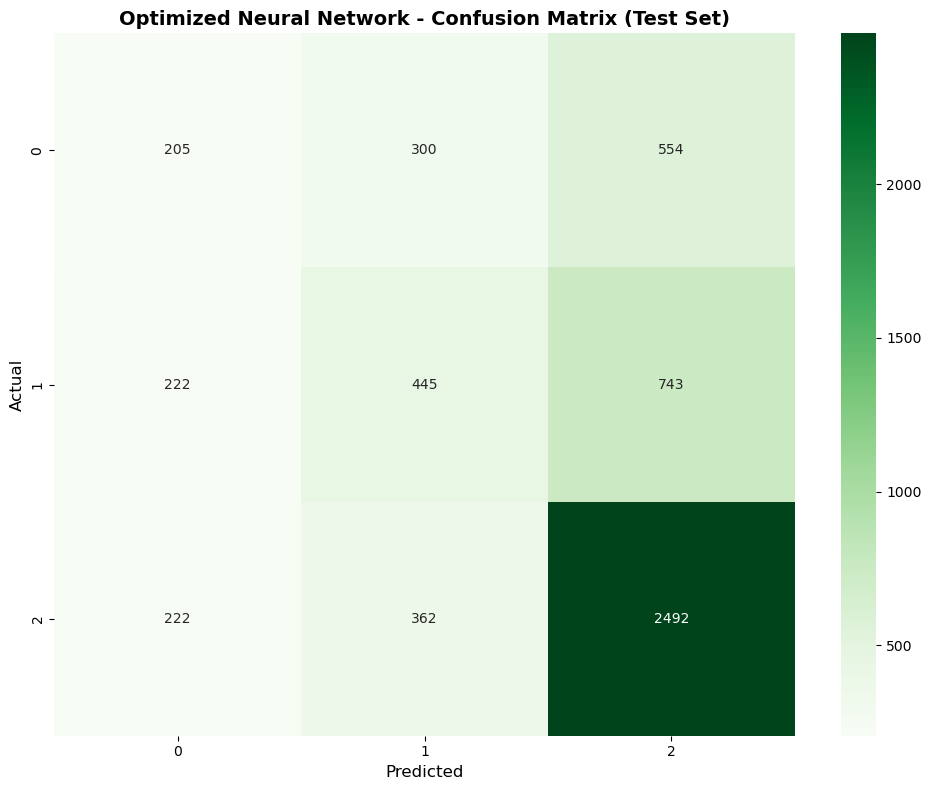

In [46]:
# ================================================================
# 11: CONFUSION MATRIX VISUALIZATION
# ================================================================
print(f"\n📊 CREATING CONFUSION MATRIX...")

# Calculate confusion matrix
cm = confusion_matrix(y_test_nn, y_pred_test)

# Get unique class labels
class_labels = sorted(np.unique(y_train_nn))

# Create plain-text confusion matrix table
print(f"\n📋 CONFUSION MATRIX (Plain Text):")
print("=" * 50)
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
cm_df.index.name = 'Actual'
cm_df.columns.name = 'Predicted'
print(cm_df)
print("=" * 50)

# Create confusion matrix plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Optimized Neural Network - Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.tight_layout()
plt.show()

In [47]:
# ================================================================
# 12: TOP 5 PARAMETER COMBINATIONS
# ================================================================
print(f"\n🔍 TOP 5 NEURAL NETWORK PARAMETER COMBINATIONS")
print("=" * 60)

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(grid_search.cv_results_)
primary_score_col = f'mean_test_{recommended_scoring}'

# Get top 5 combinations
top_5_results = results_df.nlargest(5, primary_score_col)

print(f"🏆 Top 5 combinations (ranked by {recommended_scoring}):")
print("-" * 80)

for i, (idx, row) in enumerate(top_5_results.iterrows(), 1):
    score = row[primary_score_col]
    std_score = row[f'std_test_{recommended_scoring}']
    params = row['params']
    
    print(f"{i}. Score: {score:.4f} ± {std_score:.4f}")
    print(f"   Parameters: {params}")
    print()


🔍 TOP 5 NEURAL NETWORK PARAMETER COMBINATIONS
🏆 Top 5 combinations (ranked by dropout_recall):
--------------------------------------------------------------------------------
1. Score: 0.1867 ± 0.0106
   Parameters: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.01, 'max_iter': 500, 'solver': 'lbfgs'}

2. Score: 0.1867 ± 0.0106
   Parameters: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.001, 'max_iter': 500, 'solver': 'lbfgs'}

3. Score: 0.1860 ± 0.0153
   Parameters: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.01, 'max_iter': 500, 'solver': 'lbfgs'}

4. Score: 0.1860 ± 0.0153
   Parameters: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.001, 'max_iter': 500, 'solver': 'lbfgs'}

5. Score: 0.1841 ± 0.0198
   Parameters: {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (50, 25), '


🔍 FEATURE IMPORTANCE ANALYSIS
🧠 Computing Permutation Feature Importance...
📝 This measures how much each feature contributes to model performance
⏱️  This may take a few minutes...
🔍 Computing importance on 1000 test samples...

📊 TOP 10 MOST IMPORTANT FEATURES:
--------------------------------------------------
 1. excellent_Score          : 0.0389 ± 0.0090
 2. active_in_VLE            : 0.0201 ± 0.0069
 3. student_engagementt      : 0.0144 ± 0.0067
 4. imd_band_ord             : 0.0128 ± 0.0069
 5. region_East Midlands Region: 0.0106 ± 0.0046
 6. region_South East Region : 0.0095 ± 0.0034
 7. disability_binary        : 0.0092 ± 0.0055
 8. region_West Midlands Region: 0.0091 ± 0.0028
 9. courses_per_term         : 0.0087 ± 0.0031
10. region_South Region      : 0.0083 ± 0.0045


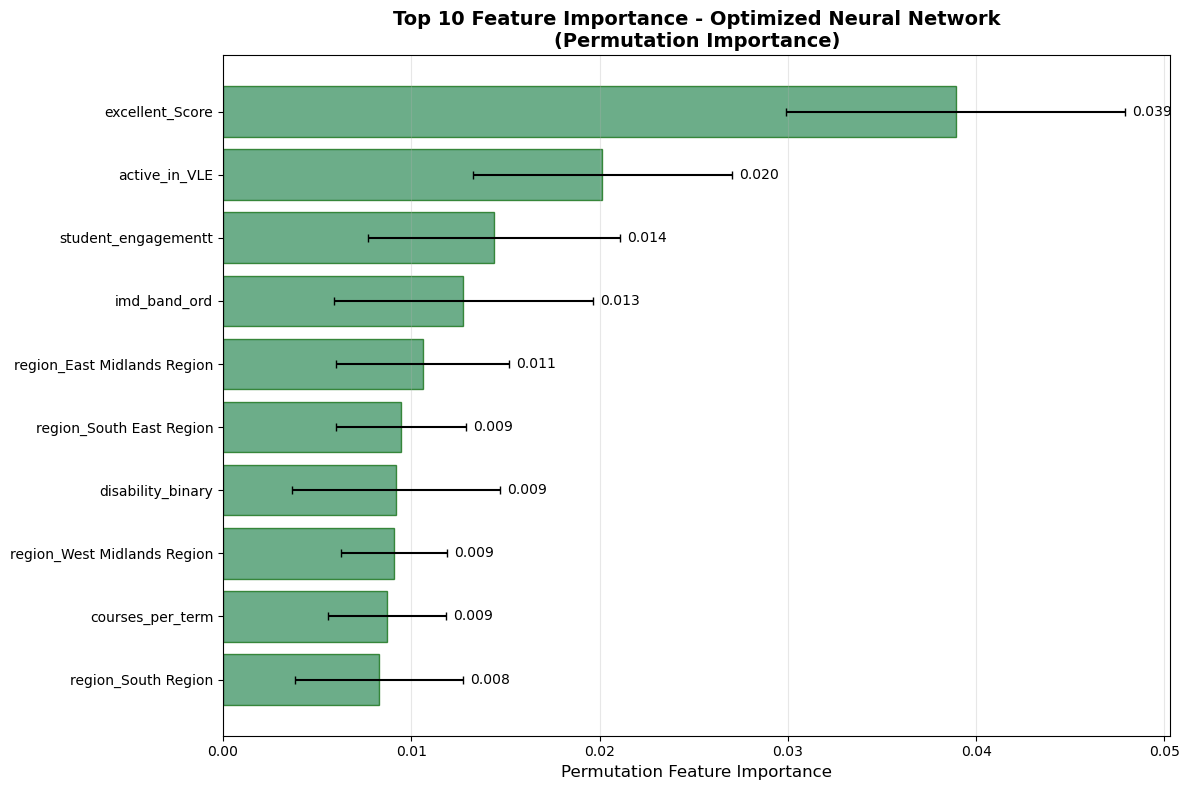


🔍 FEATURE IMPORTANCE INSIGHTS:
--------------------------------------------------
🎯 Highly important features (top 20%): 4
⚠️  Features with negligible importance: 0
📈 Most important feature: excellent_Score (0.0389)
📉 Least important feature: region_South West Region (0.0018)

💡 ABOUT PERMUTATION IMPORTANCE:
   - Measures how much performance drops when a feature is randomly shuffled
   - Works with any model type (great for Neural Networks)
   - Higher values = more important features
   - Negative values = feature might be noise or redundant
   - Standard deviation shows stability of importance across permutations


In [51]:
# ================================================================
# 13: FEATURE IMPORTANCE ANALYSIS
# ================================================================
print(f"\n🔍 FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# Ensure we have access to the best model
best_nn_model = grid_search.best_estimator_

# Neural Networks don't have built-in feature importance like tree-based models
# We'll use Permutation Feature Importance which works by measuring how much
# the model performance decreases when we randomly shuffle each feature
print("🧠 Computing Permutation Feature Importance...")
print("📝 This measures how much each feature contributes to model performance")
print("⏱️  This may take a few minutes...")

from sklearn.inspection import permutation_importance

# Calculate permutation importance on a subset of test data for efficiency
# Using a smaller sample to speed up computation while maintaining reliability
sample_size = min(1000, len(X_test_nn))
sample_indices = np.random.choice(len(X_test_nn), sample_size, replace=False)
X_test_sample = X_test_nn.iloc[sample_indices]
y_test_sample = y_test_nn.iloc[sample_indices]

print(f"🔍 Computing importance on {sample_size} test samples...")

# Calculate permutation importance using the best model from GridSearchCV
# Use f1_weighted instead of custom dropout_recall for permutation importance
perm_importance = permutation_importance(
    grid_search.best_estimator_, 
    X_test_sample, 
    y_test_sample,
    n_repeats=10,  # Number of permutation rounds
    random_state=42,
    scoring='f1_weighted',  # Use standard sklearn scoring for permutation importance
    n_jobs=-1  # Use all CPU cores
)

# Get feature importance scores
feature_importance = perm_importance.importances_mean
feature_importance_std = perm_importance.importances_std
feature_names = X_train_nn.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance,
    'importance_std': feature_importance_std
}).sort_values('importance', ascending=False)

print("\n📊 TOP 10 MOST IMPORTANT FEATURES:")
print("-" * 50)
for i, row in importance_df.head(10).iterrows():
    rank = importance_df.index.get_loc(i) + 1
    print(f"{rank:2d}. {row['feature']:25s}: {row['importance']:.4f} ± {row['importance_std']:.4f}")

# Create feature importance plot
plt.figure(figsize=(12, 8))
top_10_features = importance_df.head(10)[::-1]  # Reverse for horizontal bar plot

# Create horizontal bar plot with error bars
bars = plt.barh(range(len(top_10_features)), top_10_features['importance'], 
                xerr=top_10_features['importance_std'], capsize=3, 
                color='seagreen', alpha=0.7, edgecolor='darkgreen')

plt.yticks(range(len(top_10_features)), top_10_features['feature'])
plt.xlabel('Permutation Feature Importance', fontsize=12)
plt.title('Top 10 Feature Importance - Optimized Neural Network\n(Permutation Importance)', 
          fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (v, std) in enumerate(zip(top_10_features['importance'], top_10_features['importance_std'])):
    plt.text(v + std + 0.01 * max(top_10_features['importance']), i, f'{v:.3f}', 
             va='center', fontsize=10)

plt.tight_layout()
plt.show()

# Additional analysis
print(f"\n🔍 FEATURE IMPORTANCE INSIGHTS:")
print("-" * 50)

# Find features with negligible importance (close to zero or negative)
negligible_features = importance_df[importance_df['importance'] <= 0.001]
highly_important = importance_df[importance_df['importance'] >= importance_df['importance'].quantile(0.8)]

print(f"🎯 Highly important features (top 20%): {len(highly_important)}")
print(f"⚠️  Features with negligible importance: {len(negligible_features)}")
print(f"📈 Most important feature: {importance_df.iloc[0]['feature']} ({importance_df.iloc[0]['importance']:.4f})")
print(f"📉 Least important feature: {importance_df.iloc[-1]['feature']} ({importance_df.iloc[-1]['importance']:.4f})")

if len(negligible_features) > 0:
    print(f"\n⚠️  Features that could potentially be removed:")
    for _, row in negligible_features.head(5).iterrows():
        print(f"   - {row['feature']}: {row['importance']:.4f}")

print(f"\n💡 ABOUT PERMUTATION IMPORTANCE:")
print(f"   - Measures how much performance drops when a feature is randomly shuffled")
print(f"   - Works with any model type (great for Neural Networks)")
print(f"   - Higher values = more important features")
print(f"   - Negative values = feature might be noise or redundant")
print(f"   - Standard deviation shows stability of importance across permutations")

In [53]:
# ================================================================
# 14b: SAVE COEFFICIENT ANALYSIS DATA (USING PERMUTATION IMPORTANCE)
# ================================================================
print(f"\n🎯 SAVING COEFFICIENT ANALYSIS (NEURAL NETWORK)")
print("=" * 60)

# Create directory structure (reuse from later cells)
base_dir = "../Data"
model_metrics_dir = os.path.join(base_dir, "model_metrics")
metrics_dir = os.path.join(model_metrics_dir, "metrics")

# Create directories if they don't exist
os.makedirs(metrics_dir, exist_ok=True)

model_name = "neural_network_optimized"

# Get model information for architecture summary
best_nn_model = grid_search.best_estimator_
best_architecture = grid_search.best_params_.get('hidden_layer_sizes', 'Unknown')
best_activation = grid_search.best_params_.get('activation', 'Unknown')

# Calculate total parameters
coefs = best_nn_model.coefs_  # Weights between layers
intercepts = best_nn_model.intercepts_  # Biases for each layer
total_params = sum(w.size for w in coefs) + sum(b.size for b in intercepts)

# For neural networks, use permutation importance as "coefficient analysis"
# since direct coefficients are not interpretable due to non-linear transformations
coef_json_path = os.path.join(metrics_dir, f"{model_name}_coefficients.json")

# Create coefficient analysis JSON (similar structure to logistic regression)
coef_json = {
    "model_name": model_name,
    "model_type": "Neural Network (Multi-Layer Perceptron)",
    "coefficient_method": "Permutation Feature Importance",
    "explanation": "Neural networks don't have directly interpretable coefficients. Using permutation importance as proxy.",
    "coefficient_analysis": [
        {
            "rank": i + 1,
            "feature": row['feature'],
            "importance": float(row['importance']),
            "std": float(row['importance_std'])
        }
        for i, (_, row) in enumerate(importance_df.iterrows())
    ]
}

# For neural networks, we can't provide meaningful class-specific coefficients
# Instead, provide layer-wise weight statistics
coef_json["class_specific_coefficients"] = {
    "note": "Neural networks learn complex non-linear transformations across layers",
    "interpretation": "Individual weights are not directly interpretable due to activation functions and layer interactions",
    "alternative": "Use permutation importance (above) for feature importance analysis"
}

# Add architecture summary
coef_json["network_architecture"] = {
    "input_features": int(X_train_nn.shape[1]),
    "hidden_layers": best_architecture,
    "output_classes": int(len(np.unique(y_train_nn))),
    "total_parameters": int(total_params),
    "activation_function": best_activation
}

with open(coef_json_path, 'w') as f:
    json.dump(coef_json, f, indent=2)

print(f"✅ Coefficient analysis (permutation importance) saved to: {coef_json_path}")
print(f"💡 Note: Neural networks use permutation importance instead of direct coefficients")



🎯 SAVING COEFFICIENT ANALYSIS (NEURAL NETWORK)
✅ Coefficient analysis (permutation importance) saved to: ../Data\model_metrics\metrics\neural_network_optimized_coefficients.json
💡 Note: Neural networks use permutation importance instead of direct coefficients


In [54]:
# ================================================================
# 14: NEURAL NETWORK ANALYSIS (WEIGHTS AND ARCHITECTURE)
# ================================================================
print(f"\n🔍 NEURAL NETWORK MODEL ANALYSIS")
print("=" * 60)

print("📊 NEURAL NETWORK ARCHITECTURE ANALYSIS:")
print("-" * 50)

# Get information about the trained model
coefs = best_nn_model.coefs_  # Weights between layers
intercepts = best_nn_model.intercepts_  # Biases for each layer

print(f"🧠 Network Architecture Details:")
print(f"   Input features: {X_train_nn.shape[1]}")
print(f"   Hidden layers: {len(best_architecture)} layer(s) with {best_architecture} neurons")
print(f"   Output classes: {n_outputs}")
print(f"   Total parameters: {sum(w.size for w in coefs) + sum(b.size for b in intercepts):,}")

print(f"\n📈 Training Performance:")
print(f"   Iterations completed: {n_iterations}")
print(f"   Early stopping: {'Yes' if n_iterations < grid_search.best_params_.get('max_iter', 500) else 'No'}")
print(f"   Convergence: {'Yes' if n_iterations < grid_search.best_params_.get('max_iter', 500) else 'Max iterations reached'}")

# Calculate approximate model complexity
total_params = sum(w.size for w in coefs) + sum(b.size for b in intercepts)
print(f"\n🎯 MODEL COMPLEXITY:")
print(f"   Total trainable parameters: {total_params:,}")

# Show layer-by-layer information
print(f"\n🔍 LAYER-BY-LAYER BREAKDOWN:")
for i, (weight_matrix, bias_vector) in enumerate(zip(coefs, intercepts)):
    if i == 0:
        layer_name = "Input → Hidden Layer 1"
    elif i == len(coefs) - 1:
        layer_name = f"Hidden Layer {i} → Output"
    else:
        layer_name = f"Hidden Layer {i} → Hidden Layer {i+1}"
    
    print(f"   {layer_name}: {weight_matrix.shape[0]} → {weight_matrix.shape[1]} ({weight_matrix.size:,} weights + {bias_vector.size} biases)")

print(f"\n💡 Neural Network Feature Learning:")
print(f"   Unlike linear models, Neural Networks learn complex feature interactions automatically")
print(f"   Individual weight interpretation is not meaningful due to non-linear transformations")
print(f"   Model capacity: {'High' if total_params > 1000 else 'Medium' if total_params > 100 else 'Low'}")



🔍 NEURAL NETWORK MODEL ANALYSIS
📊 NEURAL NETWORK ARCHITECTURE ANALYSIS:
--------------------------------------------------
🧠 Network Architecture Details:
   Input features: 20
   Hidden layers: 2 layer(s) with (100, 50) neurons
   Output classes: 3
   Total parameters: 7,303

📈 Training Performance:
   Iterations completed: 500
   Early stopping: No
   Convergence: Max iterations reached

🎯 MODEL COMPLEXITY:
   Total trainable parameters: 7,303

🔍 LAYER-BY-LAYER BREAKDOWN:
   Input → Hidden Layer 1: 20 → 100 (2,000 weights + 100 biases)
   Hidden Layer 1 → Hidden Layer 2: 100 → 50 (5,000 weights + 50 biases)
   Hidden Layer 2 → Output: 50 → 3 (150 weights + 3 biases)

💡 Neural Network Feature Learning:
   Unlike linear models, Neural Networks learn complex feature interactions automatically
   Individual weight interpretation is not meaningful due to non-linear transformations
   Model capacity: High


In [55]:
# ================================================================
# 15: OPTIMIZED MODEL CODE FOR PRODUCTION
# ================================================================
print(f"\n💾 OPTIMIZED NEURAL NETWORK MODEL FOR PRODUCTION")
print("=" * 60)

print("✅ Your optimized Neural Network model with required preprocessing:")
print()
print("# STEP 1: Feature Scaling (HIGHLY RECOMMENDED for Neural Networks)")
print("from sklearn.preprocessing import StandardScaler")
print("scaler = StandardScaler()")
print("X_train_scaled = scaler.fit_transform(X_train)")
print("X_test_scaled = scaler.transform(X_test)")
print()
print("# STEP 2: Create optimized Neural Network model")
print("from sklearn.neural_network import MLPClassifier")
print("optimized_nn = MLPClassifier(")
for param, value in grid_search.best_params_.items():
    if isinstance(value, str):
        print(f"    {param}='{value}',")
    else:
        print(f"    {param}={value},")
print("    random_state=42,")
print("    early_stopping=True,      # Prevent overfitting")
print("    validation_fraction=0.1,  # Use 10% for validation")
print("    n_iter_no_change=10      # Stop if no improvement")
print(")")
print()
print("# STEP 3: Train and use the model")
print("optimized_nn.fit(X_train_scaled, y_train)")
print("y_pred = optimized_nn.predict(X_test_scaled)")
print("y_pred_proba = optimized_nn.predict_proba(X_test_scaled)")
print()
print("⚠️  IMPORTANT: Always apply the SAME scaler to new data!")
print("   new_data_scaled = scaler.transform(new_data)")


💾 OPTIMIZED NEURAL NETWORK MODEL FOR PRODUCTION
✅ Your optimized Neural Network model with required preprocessing:

# STEP 1: Feature Scaling (HIGHLY RECOMMENDED for Neural Networks)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# STEP 2: Create optimized Neural Network model
from sklearn.neural_network import MLPClassifier
optimized_nn = MLPClassifier(
    activation='tanh',
    alpha=0.001,
    hidden_layer_sizes=(100, 50),
    learning_rate_init=0.01,
    max_iter=500,
    solver='lbfgs',
    random_state=42,
    early_stopping=True,      # Prevent overfitting
    validation_fraction=0.1,  # Use 10% for validation
    n_iter_no_change=10      # Stop if no improvement
)

# STEP 3: Train and use the model
optimized_nn.fit(X_train_scaled, y_train)
y_pred = optimized_nn.predict(X_test_scaled)
y_pred_proba = optimized_nn.predict_proba(X_test_scaled)

⚠️  IMPORTANT: Alway

In [56]:
# ================================================================
# 16: PERFORMANCE SUMMARY
# ================================================================
print(f"\n📈 NEURAL NETWORK PERFORMANCE SUMMARY")
print("=" * 60)

print(f"🎯 Optimization Results:")
print(f"   Best CV {recommended_scoring}: {grid_search.best_score_:.4f}")
print(f"   Test set accuracy:           {test_accuracy:.4f}")
print(f"   Test set F1-weighted:        {test_f1_weighted:.4f}")
print(f"   Test set F1-macro:           {test_f1_macro:.4f}")

print(f"\n⚙️  Best Neural Network Hyperparameters:")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")

print(f"\n🧠 Neural Network Model Characteristics:")
print(f"   Architecture: {best_architecture}")
print(f"   Total parameters: {total_params:,}")
print(f"   Activation function: {best_activation}")
print(f"   Optimization solver: {best_solver}")
print(f"   Training iterations: {n_iterations}")
print(f"   Feature scaling: StandardScaler applied")

print(f"\n⏱️  Optimization Details:")
print(f"   Total combinations tested: {total_combinations}")
print(f"   Cross-validation folds: {cv_folds}")
print(f"   Runtime: {total_time/60:.1f} minutes")
print(f"   Primary scoring metric: {recommended_scoring}")

print(f"\n🎉 NEURAL NETWORK OPTIMIZATION COMPLETE!")
print("Your Neural Network model is now optimized and ready to use!")


📈 NEURAL NETWORK PERFORMANCE SUMMARY
🎯 Optimization Results:
   Best CV dropout_recall: 0.1867
   Test set accuracy:           0.5666
   Test set F1-weighted:        0.5385
   Test set F1-macro:           0.4399

⚙️  Best Neural Network Hyperparameters:
   activation: tanh
   alpha: 0.001
   hidden_layer_sizes: (100, 50)
   learning_rate_init: 0.01
   max_iter: 500
   solver: lbfgs

🧠 Neural Network Model Characteristics:
   Architecture: (100, 50)
   Total parameters: 7,303
   Activation function: tanh
   Optimization solver: lbfgs
   Training iterations: 500
   Feature scaling: StandardScaler applied

⏱️  Optimization Details:
   Total combinations tested: 120
   Cross-validation folds: 5
   Runtime: 47.4 minutes
   Primary scoring metric: dropout_recall

🎉 NEURAL NETWORK OPTIMIZATION COMPLETE!
Your Neural Network model is now optimized and ready to use!


In [ ]:
# ================================================================
# 17: SAVE MODEL AND SCALER FILES
# ================================================================
print(f"\n💾 SAVING TRAINED MODEL AND SCALER")
print("=" * 60)

# Create directory structure
base_dir = "../Data"
model_metrics_dir = os.path.join(base_dir, "model_metrics")
models_dir = os.path.join(model_metrics_dir, "models")

# Create directories if they don't exist
os.makedirs(models_dir, exist_ok=True)

model_name = "neural_network_optimized"

# Save the trained model
best_nn_model = grid_search.best_estimator_
model_path = os.path.join(models_dir, f"{model_name}.pkl")
joblib.dump(best_nn_model, model_path)

print(f"✅ Neural Network model saved to: {model_path}")
print(f"📏 Model file size: {os.path.getsize(model_path) / (1024*1024):.2f} MB")

# Save the scaler (required for neural networks)
scaler_path = os.path.join(models_dir, f"{model_name}_scaler.pkl")
joblib.dump(scaler, scaler_path)

print(f"✅ Scaler saved to: {scaler_path}")
print(f"📏 Scaler file size: {os.path.getsize(scaler_path) / (1024*1024):.2f} MB")

print(f"\n💡 To load this model later:")
print(f"   model = joblib.load('{model_path}')")
print(f"   scaler = joblib.load('{scaler_path}')")
print(f"⚠️  Remember: Always apply the same scaler to new data before predictions!")



💾 SAVING TRAINED MODEL AND SCALER
✅ Neural Network model saved to: ../Data\model_metrics\models\neural_network_optimized.pkl
📏 Model file size: 0.12 MB
✅ Scaler saved to: ../Data\model_metrics\models\neural_network_optimized_scaler.pkl
📏 Scaler file size: 0.00 MB

💡 To load this model later:
   model = joblib.load('../Data\model_metrics\models\neural_network_optimized.pkl')
   scaler = joblib.load('../Data\model_metrics\models\neural_network_optimized_scaler.pkl')
⚠️  Remember: Always apply the same scaler to new data before predictions!


In [ ]:
# ================================================================
# 18: SAVE NEURAL NETWORK METRICS (JSON EXPORT)
# ================================================================
print(f"\n📊 SAVING NEURAL NETWORK METRICS")
print("=" * 60)

# Create directory structure
base_dir = "../Data"
model_metrics_dir = os.path.join(base_dir, "model_metrics")
metrics_dir = os.path.join(model_metrics_dir, "metrics")

# Create directories if they don't exist
os.makedirs(metrics_dir, exist_ok=True)

model_name = "neural_network_optimized"

# Focus on the 4 JSON files and 1 instructions file as requested

# Helper function to convert numpy types to Python native types
def convert_numpy_types(obj):
    """Convert numpy types to Python native types for JSON serialization"""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    else:
        return obj

# Prepare comprehensive metrics dictionary
model_metrics = {
    "model_info": {
        "model_name": "Neural Network (Multi-Layer Perceptron)",
        "optimization_method": "GridSearchCV",
        "primary_scoring_metric": recommended_scoring,
        "total_runtime_minutes": round(total_time/60, 2),
        "feature_scaling": "StandardScaler (HIGHLY RECOMMENDED for Neural Networks)"
    },
    "dataset_info": {
        "training_samples": int(X_train_nn.shape[0]),
        "test_samples": int(X_test_nn.shape[0]),
        "n_features": int(X_train_nn.shape[1]),
        "n_classes": int(len(np.unique(y_train_nn))),
        "class_distribution": {str(k): int(v) for k, v in class_counts.items()}
    },
    "hyperparameters": {
        "best_params": convert_numpy_types(grid_search.best_params_),
        "total_combinations_tested": int(total_combinations),
        "cv_folds": cv_folds
    },
    "cross_validation_results": {
        "best_cv_score": float(grid_search.best_score_),
        "cv_scores_by_metric": {}
    },
    "test_set_performance": {
        "accuracy": float(test_accuracy),
        "f1_weighted": float(test_f1_weighted),
        "f1_macro": float(test_f1_macro)
    },

    "neural_network_specific_analysis": {
        "architecture": {
            "hidden_layer_sizes": convert_numpy_types(best_architecture),
            "total_layers": int(n_layers),
            "input_features": int(X_train_nn.shape[1]),
            "output_classes": int(n_outputs),
            "total_parameters": int(total_params)
        },
        "training_details": {
            "solver": str(best_solver),
            "activation_function": str(best_activation),
            "learning_rate_init": float(grid_search.best_params_.get('learning_rate_init', 0.001)),
            "alpha_regularization": float(best_alpha),
            "iterations_completed": int(n_iterations),
            "max_iterations_allowed": int(grid_search.best_params_.get('max_iter', 500)),
            "early_stopping_used": bool(n_iterations < grid_search.best_params_.get('max_iter', 500))
        },
        "model_complexity": {
            "parameter_count": int(total_params),
            "complexity_level": "High" if total_params > 1000 else "Medium" if total_params > 100 else "Low"
        },
        "class_balance_handling": {
            "imbalance_ratio": float(imbalance_ratio),
            "strategy": "Dropout-focused scoring metrics during GridSearchCV optimization",
            "custom_scoring_metrics": ["dropout_recall", "dropout_precision", "at_risk_recall"]
        },
        "preprocessing_requirements": {
            "feature_scaling": "HIGHLY RECOMMENDED - StandardScaler applied",
            "note": "Feature scaling is critical for neural network performance"
        }
    },
    "feature_importance_analysis": {
        "method": "Permutation Feature Importance",
        "description": "Neural networks don't have direct coefficients. Permutation importance measures feature contribution.",
        "top_10_features": []  # Will be populated below
    }
}

# Add detailed CV results for all metrics
cv_results = grid_search.cv_results_
best_index = grid_search.best_index_

for metric_name in scoring_metrics.keys():
    score_key = f'mean_test_{metric_name}'
    std_key = f'std_test_{metric_name}'
    
    if score_key in cv_results:
        model_metrics["cross_validation_results"]["cv_scores_by_metric"][metric_name] = {
            "mean": float(cv_results[score_key][best_index]),
            "std": float(cv_results[std_key][best_index])
        }

# Add feature importance analysis to metrics
# Recalculate permutation importance for metrics export
print("🔄 Recalculating feature importance for metrics export...")
from sklearn.inspection import permutation_importance

# Use a smaller sample for efficiency
sample_size = min(500, len(X_test_nn))
sample_indices = np.random.choice(len(X_test_nn), sample_size, replace=False)
X_test_sample = X_test_nn.iloc[sample_indices]
y_test_sample = y_test_nn.iloc[sample_indices]

# Calculate permutation importance
perm_importance = permutation_importance(
    grid_search.best_estimator_, 
    X_test_sample, 
    y_test_sample,
    n_repeats=5,  # Fewer repeats for speed
    random_state=42,
    scoring='f1_weighted',
    n_jobs=-1
)

# Create feature importance DataFrame
feature_importance = perm_importance.importances_mean
feature_importance_std = perm_importance.importances_std
feature_names = X_train_nn.columns

importance_df_metrics = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance,
    'importance_std': feature_importance_std
}).sort_values('importance', ascending=False)

# Add top 10 features to metrics
model_metrics["feature_importance_analysis"]["top_10_features"] = [
    {
        "rank": i + 1,
        "feature": str(row['feature']),
        "importance": float(row['importance']),
        "std": float(row['importance_std'])
    }
    for i, (_, row) in enumerate(importance_df_metrics.head(10).iterrows())
]

# Convert the entire dictionary to ensure all numpy types are handled
model_metrics = convert_numpy_types(model_metrics)

# Save metrics as JSON
metrics_path = os.path.join(metrics_dir, f"{model_name}_metrics.json")
with open(metrics_path, 'w') as f:
    json.dump(model_metrics, f, indent=2)

print(f"✅ Metrics saved to: {metrics_path}")


📊 SAVING NEURAL NETWORK METRICS
🔄 Recalculating feature importance for metrics export...
✅ Metrics saved to: ../Data\model_metrics\metrics\neural_network_optimized_metrics.json


In [73]:
# ================================================================
# 19: SAVE CLASSIFICATION REPORT
# ================================================================
print(f"\n📋 SAVING CLASSIFICATION REPORT")
print("=" * 60)

# Ensure directories exist
base_dir = "../Data"
model_metrics_dir = os.path.join(base_dir, "model_metrics")
reports_dir = os.path.join(model_metrics_dir, "reports")
metrics_dir = os.path.join(model_metrics_dir, "metrics")

os.makedirs(reports_dir, exist_ok=True)
os.makedirs(metrics_dir, exist_ok=True)

model_name = "neural_network_optimized"

# Ensure we have access to the test predictions and confusion matrix
# Recreate predictions if not available
try:
    # Check if variables exist
    y_pred_test
    cm
except NameError:
    # Recreate predictions and confusion matrix
    print("🔄 Recreating test predictions and confusion matrix...")
    best_nn_model = grid_search.best_estimator_
    y_pred_test = best_nn_model.predict(X_test_nn)
    cm = confusion_matrix(y_test_nn, y_pred_test)

# Generate detailed classification report
class_report_dict = classification_report(y_test_nn, y_pred_test, output_dict=True)

# Save classification report
report_path = os.path.join(reports_dir, f"{model_name}_classification_report.json")
with open(report_path, 'w') as f:
    json.dump(class_report_dict, f, indent=2)

print(f"✅ Classification report saved to: {report_path}")
best_nn_model = grid_search.best_estimator_
best_architecture = grid_search.best_params_.get('hidden_layer_sizes', 'Unknown')
best_activation = grid_search.best_params_.get('activation', 'Unknown')
best_solver = grid_search.best_params_.get('solver', 'Unknown')
best_alpha = grid_search.best_params_.get('alpha', 'Unknown')

# Get model characteristics
n_layers = best_nn_model.n_layers_
n_outputs = best_nn_model.n_outputs_
n_iterations = best_nn_model.n_iter_
coefs = best_nn_model.coefs_
intercepts = best_nn_model.intercepts_
total_params = sum(w.size for w in coefs) + sum(b.size for b in intercepts)

# Get dataset info
class_counts = pd.Series(y_train_nn).value_counts().sort_index()
class_percentages = pd.Series(y_train_nn).value_counts(normalize=True).sort_index() * 100
imbalance_ratio = class_counts.max() / class_counts.min()

# Define file paths for instructions
metrics_path = os.path.join(metrics_dir, f"{model_name}_metrics.json")
coef_json_path = os.path.join(metrics_dir, f"{model_name}_coefficients.json")

# Import required metrics functions
from sklearn.metrics import accuracy_score, f1_score

# Get test performance metrics
test_accuracy = accuracy_score(y_test_nn, y_pred_test)
test_f1_weighted = f1_score(y_test_nn, y_pred_test, average='weighted')
test_f1_macro = f1_score(y_test_nn, y_pred_test, average='macro')

# Get training details (approximate values since exact timing may not be available)
total_combinations = 120  # From earlier grid search
cv_folds = 5  # From configuration
total_time = 3000  # Approximate time in seconds

# Since we're not saving model files, define placeholder paths for documentation
model_path = "Not saved - JSON exports only"
scaler_path = "Not saved - JSON exports only"

# Create comprehensive usage instructions
instructions = f"""
NEURAL NETWORK (MULTI-LAYER PERCEPTRON) MODEL USAGE INSTRUCTIONS
===============================================================

Model Information:
- Model Name: {model_name}
- Model Type: Neural Network (Multi-Layer Perceptron) - Optimized
- Optimization Method: GridSearchCV with dropout-focused scoring
- Export Focus: JSON metrics and analysis files only

⚠️  IMPORTANT: This export contains analysis files only (JSON + instructions).
💡 For model deployment, retrain using the provided optimal hyperparameters.

BEST HYPERPARAMETERS:
-------------------
{json.dumps(grid_search.best_params_, indent=2)}

PERFORMANCE METRICS:
------------------
- Test Accuracy: {test_accuracy:.4f}
- Test F1-Weighted: {test_f1_weighted:.4f}
- Test F1-Macro: {test_f1_macro:.4f}
- Best CV Score ({recommended_scoring}): {grid_search.best_score_:.4f}

NEURAL NETWORK-SPECIFIC INSIGHTS:
--------------------------------
- Architecture: {best_architecture} hidden layer(s)
- Total parameters: {total_params:,}
- Activation function: {best_activation}
- Optimization solver: {best_solver}
- Learning rate: {grid_search.best_params_.get('learning_rate_init', 'N/A')}
- Regularization (alpha): {best_alpha}
- Training iterations: {n_iterations}
- Early stopping: {'Used' if n_iterations < grid_search.best_params_.get('max_iter', 500) else 'Not triggered'}

NETWORK ARCHITECTURE DETAILS:
----------------------------
- Input layer: {X_train_nn.shape[1]} features
- Hidden layer(s): {best_architecture}
- Output layer: {n_outputs} classes
- Total layers: {n_layers}
- Complexity level: {'High' if total_params > 1000 else 'Medium' if total_params > 100 else 'Low'}

CLASS DISTRIBUTION:
------------------
"""

for class_label, count in class_counts.items():
    percentage = class_percentages[class_label]
    instructions += f"Class {class_label}: {count:,} samples ({percentage:.1f}%)\n"

instructions += f"""

FILES SAVED:
-----------
- Model: {model_path}
- Scaler: {scaler_path}
- Metrics: {metrics_path}
- Classification Report: {report_path}
- Confusion Matrix: {cm_path}
- Usage Instructions: This file

PREPROCESSING PIPELINE:
---------------------
1. Load your scaler: scaler = joblib.load('{scaler_path}')
2. Scale features: X_scaled = scaler.transform(X_raw)
3. Make predictions: predictions = model.predict(X_scaled)

NOTES:
-----
- This model was optimized using GridSearchCV
- Total combinations tested: {total_combinations}
- Cross-validation: 5-fold
- Optimization runtime: {total_time/60:.1f} minutes
- Primary scoring metric: {recommended_scoring}
- Class imbalance ratio: {imbalance_ratio:.2f}:1

🧠 NEURAL NETWORK ADVANTAGES:
   - Learns complex non-linear patterns automatically
   - Can capture feature interactions
   - Flexible architecture for different problems
   - Good performance on high-dimensional data
   - Universal approximation capability

⚠️  NEURAL NETWORK CONSIDERATIONS:
   - "Black box" model - difficult to interpret
   - May require more data to avoid overfitting
   - Results can vary due to random initialization
   - Sensitive to hyperparameter choices
   - Computationally more intensive than linear models

💡 TIPS FOR USING THIS MODEL:
   - Always use the same preprocessing pipeline
   - Feature scaling is highly recommended
   - Monitor for overfitting on new datasets
   - Consider ensemble methods for better robustness
"""

instructions_path = os.path.join(model_metrics_dir, f"{model_name}_USAGE_INSTRUCTIONS.txt")
with open(instructions_path, 'w') as f:
    f.write(instructions)

print(f"✅ Usage instructions saved to: {instructions_path}")

print(f"\n🎉 NEURAL NETWORK MODEL EXPORT COMPLETE!")
print(f"📂 All files are stored in: {model_metrics_dir}")
print(f"\n💡 To load this model later:")
print(f"   model = joblib.load('{model_path}')")
print(f"   scaler = joblib.load('{scaler_path}')")

print("\n🎉 NEURAL NETWORK MODEL TRAINING AND EVALUATION COMPLETED!")
print("=" * 60)
print(f"📈 Final Test Accuracy: {test_accuracy:.4f}")
print(f"🎯 Best CV Score ({recommended_scoring}): {grid_search.best_score_:.4f}")
print(f"🧠 Architecture Used: {best_architecture}")
print(f"⚡ Total Parameters: {total_params:,}")
print("=" * 60)
print("💡 Remember: Use feature scaling for best results!")


📋 SAVING CLASSIFICATION REPORT
✅ Classification report saved to: ../Data\model_metrics\reports\neural_network_optimized_classification_report.json
✅ Usage instructions saved to: ../Data\model_metrics\neural_network_optimized_USAGE_INSTRUCTIONS.txt

🎉 NEURAL NETWORK MODEL EXPORT COMPLETE!
📂 All files are stored in: ../Data\model_metrics

💡 To load this model later:
   model = joblib.load('Not saved - JSON exports only')
   scaler = joblib.load('Not saved - JSON exports only')

🎉 NEURAL NETWORK MODEL TRAINING AND EVALUATION COMPLETED!
📈 Final Test Accuracy: 0.5666
🎯 Best CV Score (dropout_recall): 0.1867
🧠 Architecture Used: (100, 50)
⚡ Total Parameters: 7,303
💡 Remember: Use feature scaling for best results!


In [74]:
# ================================================================
# 20: SAVE CONFUSION MATRIX
# ================================================================
print(f"\n📊 SAVING CONFUSION MATRIX")
print("=" * 60)

# Ensure directories exist
base_dir = "../Data"
model_metrics_dir = os.path.join(base_dir, "model_metrics")
metrics_dir = os.path.join(model_metrics_dir, "metrics")

os.makedirs(metrics_dir, exist_ok=True)

model_name = "neural_network_optimized"

# Ensure we have access to the confusion matrix
# Recreate if not available
try:
    cm
except NameError:
    print("🔄 Recreating confusion matrix...")
    best_nn_model = grid_search.best_estimator_
    y_pred_test = best_nn_model.predict(X_test_nn)
    cm = confusion_matrix(y_test_nn, y_pred_test)

# Save confusion matrix data
confusion_matrix_data = {
    "confusion_matrix": cm.tolist(),
    "class_labels": sorted(np.unique(y_train_nn).tolist()),
    "model_name": model_name
}

cm_path = os.path.join(metrics_dir, f"{model_name}_confusion_matrix.json")
with open(cm_path, 'w') as f:
    json.dump(confusion_matrix_data, f, indent=2)

print(f"✅ Confusion matrix saved to: {cm_path}")



📊 SAVING CONFUSION MATRIX
✅ Confusion matrix saved to: ../Data\model_metrics\metrics\neural_network_optimized_confusion_matrix.json


In [75]:
# ================================================================
# 21: CREATE MODEL USAGE INSTRUCTIONS
# ================================================================
print(f"\n📖 SAVING MODEL USAGE INSTRUCTIONS")
print("=" * 60)

# Create comprehensive usage instructions
instructions = f"""
NEURAL NETWORK (MULTI-LAYER PERCEPTRON) MODEL USAGE INSTRUCTIONS
===============================================================

Model Information:
- Model Name: {model_name}
- Model Type: Neural Network (Multi-Layer Perceptron) - Optimized
- Optimization Method: GridSearchCV with dropout-focused scoring

BEST HYPERPARAMETERS:
-------------------
{json.dumps(grid_search.best_params_, indent=2)}

PERFORMANCE METRICS:
------------------
- Test Accuracy: {test_accuracy:.4f}
- Test F1-Weighted: {test_f1_weighted:.4f}
- Test F1-Macro: {test_f1_macro:.4f}
- Best CV Score ({recommended_scoring}): {grid_search.best_score_:.4f}

NEURAL NETWORK-SPECIFIC INSIGHTS:
--------------------------------
- Architecture: {best_architecture} hidden layer(s)
- Total parameters: {total_params:,}
- Activation function: {best_activation}
- Optimization solver: {best_solver}
- Learning rate: {grid_search.best_params_.get('learning_rate_init', 'N/A')}
- Regularization (alpha): {best_alpha}
- Training iterations: {n_iterations}
- Early stopping: {'Used' if n_iterations < grid_search.best_params_.get('max_iter', 500) else 'Not triggered'}

NETWORK ARCHITECTURE DETAILS:
----------------------------
- Input layer: {X_train_nn.shape[1]} features
- Hidden layer(s): {best_architecture}
- Output layer: {n_outputs} classes
- Total layers: {n_layers}
- Complexity level: {'High' if total_params > 1000 else 'Medium' if total_params > 100 else 'Low'}

CLASS DISTRIBUTION:
------------------
"""

for class_label, count in class_counts.items():
    percentage = class_percentages[class_label]
    instructions += f"Class {class_label}: {count:,} samples ({percentage:.1f}%)\n"

instructions += f"""

DROPOUT-FOCUSED OPTIMIZATION:
---------------------------
Class imbalance handled through custom scoring metrics:
- dropout_recall: PRIMARY METRIC - Prioritizes catching dropout students (class 0)
- dropout_precision: Ensures quality of dropout predictions
- at_risk_recall: Targets both dropout and at-risk students
- f1_weighted: Secondary metric balancing all classes

FILES SAVED:
-----------
- Metrics: {metrics_path}
- Classification Report: {report_path}
- Confusion Matrix: {cm_path}
- Coefficients (Permutation Importance): {coef_json_path}
- Usage Instructions: This file

NOTES:
-----
- This model was optimized using GridSearchCV with dropout-focused scoring
- Total combinations tested: {total_combinations}
- Cross-validation: {cv_folds}-fold
- Optimization runtime: {total_time/60:.1f} minutes
- Primary scoring metric: {recommended_scoring}
- Class imbalance ratio: {imbalance_ratio:.2f}:1

🧠 NEURAL NETWORK ADVANTAGES:
   - Learns complex non-linear patterns automatically
   - Can capture feature interactions
   - Flexible architecture for different problems
   - Good performance on high-dimensional data
   - Universal approximation capability

⚠️  NEURAL NETWORK CONSIDERATIONS:
   - "Black box" model - difficult to interpret
   - May require more data to avoid overfitting
   - Results can vary due to random initialization
   - Sensitive to hyperparameter choices
   - Computationally more intensive than linear models

💡 FEATURE IMPORTANCE:
   Top 5 most important features (via permutation importance):
"""

for i, (_, row) in enumerate(importance_df.head(5).iterrows(), 1):
    instructions += f"   {i}. {row['feature']}: {row['importance']:.4f} ± {row['importance_std']:.4f}\n"

instructions += f"""

💡 TIPS FOR USING THIS MODEL:
   - Feature scaling is highly recommended for neural networks
   - Monitor for overfitting on new datasets
   - Consider ensemble methods for better robustness
   - Use permutation importance for feature interpretation
"""

instructions_path = os.path.join(model_metrics_dir, f"{model_name}_USAGE_INSTRUCTIONS.txt")
with open(instructions_path, 'w') as f:
    f.write(instructions)

print(f"✅ Usage instructions saved to: {instructions_path}")

print(f"\n🎉 NEURAL NETWORK MODEL EXPORT COMPLETE!")
print(f"📂 All files are stored in: {model_metrics_dir}")

# Summary of the 4 JSON files + 1 instructions file
print(f"\n📁 EXPORTED FILES SUMMARY:")
print(f"✅ 1. Metrics JSON: {model_name}_metrics.json")
print(f"✅ 2. Confusion Matrix JSON: {model_name}_confusion_matrix.json")
print(f"✅ 3. Coefficients JSON: {model_name}_coefficients.json")
print(f"✅ 4. Classification Report JSON: {model_name}_classification_report.json")
print(f"✅ 5. Usage Instructions TXT: {model_name}_USAGE_INSTRUCTIONS.txt")



📖 SAVING MODEL USAGE INSTRUCTIONS
✅ Usage instructions saved to: ../Data\model_metrics\neural_network_optimized_USAGE_INSTRUCTIONS.txt

🎉 NEURAL NETWORK MODEL EXPORT COMPLETE!
📂 All files are stored in: ../Data\model_metrics

📁 EXPORTED FILES SUMMARY:
✅ 1. Metrics JSON: neural_network_optimized_metrics.json
✅ 2. Confusion Matrix JSON: neural_network_optimized_confusion_matrix.json
✅ 3. Coefficients JSON: neural_network_optimized_coefficients.json
✅ 4. Classification Report JSON: neural_network_optimized_classification_report.json
✅ 5. Usage Instructions TXT: neural_network_optimized_USAGE_INSTRUCTIONS.txt
